## Kwestie techniczne
Ładowanie bibliotek oraz własna klasa do tworzenia modeli regresji liniowej.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import math
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from scipy.optimize import curve_fit
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

In [2]:
# --- Basic Linear Regression Class
class _LinRegBasicModel:
  def __init__(self, Y, X, echo=False):
    if echo:
      print("TASK: Build linear regression model...")
    # --- Type check for X
    if echo:
      print("  1. Validating data.")
    if isinstance(X, np.ndarray):
      if len(X.shape) == 1:
        self.p = 2
      else:
        self.p = X.shape[1] + 1
      self.n = X.shape[0]
      self.X = np.c_[np.repeat(1, self.n).reshape(self.n, 1), X]
      self.var_names = ["Intercept"] + [f"V{i}" for i in range(1, self.p)]
    elif isinstance(X, pd.DataFrame):
      self.p = X.shape[1] + 1
      self.n = X.shape[0]
      self.X = np.c_[np.repeat(1, self.n).reshape(self.n, 1), X.to_numpy()]
      if list(X.columns) == [i for i in range(len(X.columns))]:
        self.var_names = ["Intercept"] + [f"V{i}" for i in range(1, self.p)]
      else:
        self.var_names = ["Intercept"] + list(X.columns)
    elif isinstance(X, pd.Series):
      self.p = 2
      self.n = X.shape[0]
      self.X = np.c_[np.repeat(1, self.n).reshape(self.n, 1), X.to_numpy().reshape((self.n, 1))]
      self.var_names = ["Intercept", "X"]
    else:
      print("Unsupported data matrix (X) type:", type(X))

    # --- Check if Y has the same length as data
    if echo:
      print("  2. Validating response vector.")
    if isinstance(Y, np.ndarray):
      if len(Y.shape) == 1:
        if Y.shape[0] != self.n:
          raise ValueError("Value vector (Y) has different length that data (X).")
        self.Y = Y.reshape(self.n, 1)
      elif len(Y.shape) == 2:
        if Y.shape[0] != self.n:
          raise ValueError("Value vector (Y) has different length that data (X).")
        if Y.shape[1] != 1:
          raise ValueError("Your value vector (Y) has more that one column.")
        self.Y = Y.reshape(self.n, 1)
      else:
        raise ValueError("Your value vector is invalid.")
      self.var_names = ["Y"] + self.var_names
    elif isinstance(Y, pd.DataFrame):
      if Y.shape[0] != self.n:
        raise ValueError("Value vector (Y) has different length that data (X).")
      self.Y = Y.to_numpy()
      if Y.columns[0] == 0:
        self.var_names = ["Y"] + self.var_names
      else:
        self.var_names = [Y.columns[0]] + self.var_names
    elif isinstance(Y, pd.Series):
      if Y.shape[0] != self.n:
        raise ValueError("Value vector (Y) has different length that data (X).")
      self.Y = Y.to_numpy().reshape((self.n, 1))
      self.var_names = ["Y"] + self.var_names

    # Informative form of data
    self.data_matrix = pd.DataFrame(np.c_[self.Y, self.X], columns=self.var_names)

    # SVD decomposition
    if echo:
      print("  3. Decomposing X with using SVD method.")
    self.U, self.D, self.Vt = np.linalg.svd(self.X, full_matrices=False)

    # Calculate estimators
    if echo:
      print("  4. Calculating LSM estimators.")
    self.XX_inv = self.Vt.transpose() @ np.diag(1 / (self.D * self.D)) @ self.Vt
    self.beta = np.squeeze(self.XX_inv @ (self.X.transpose() @ self.Y))

    # Hat matrix and prediction
    if echo:
      print("  5. Calculating hat matrix and Y predictions.")
    self.H = self.U @ self.U.transpose()
    self.Y_pred = self.H @ self.Y

    # Rating the model
    if echo:
      print("  6. Rating the model.")
    self.SST = Y.transpose() @ Y - self.n * Y.mean()
    self.SSE = (Y.transpose() @ Y - Y.transpose() @ self.Y_pred)[0]
    self.SSR = self.SST - self.SSE
    self.R2 = self.SSR / self.SST
    self.R2_adj = 1 - self.SSE * (self.n - 1) / self.SST / (self.n - self.p)

    # Estimators and statistics
    if echo:
      print("  7. Estimating error and calculating statistics.")
    self.S2 = self.SSE / (self.n - self.p)
    self.SE_beta = np.sqrt(self.S2 * np.diag(self.XX_inv))
    self.F_stat = self.SSR * (self.n - self.p) / self.SSE / (self.p - 1)
    self.F_stat_pvalue = 1 - stats.f(self.p - 1, self.n - self.p).cdf(self.F_stat)
    self.t_stat = self.beta / self.SE_beta
    self.t_stat_pvalues = 2 * (1 - stats.t(self.n - self.p).cdf(np.abs(self.t_stat)))

    # Calculating residuals
    if echo:
      print("  8. Calculating residuals.\n")
    self._res = np.squeeze(self.Y - self.Y_pred)
    self._res_stud = self._res / np.sqrt(self.S2 * (1 - np.diag(self.H)))
    self._res_mod = self._res / (1 - np.diag(self.H))
    self._res_mod_stud = self._res_mod / np.sqrt(((self.n - self.p) * (1 - np.diag(self.H)) * self.S2 - self._res ** 2) / (self.n - self.p - 1))
    self.cook_dist = self._res_mod * np.diag(self.H) / self.p / (1 - np.diag(self.H))
    self.residuals = pd.DataFrame({
      "fitValue": self.Y_pred.squeeze(),
      "Residue": self._res,
      "stdResidue": self._res_stud,
      "modResidue": self._res_mod,
      "modStdResidue": self._res_mod_stud,
      "CooksDist": self.cook_dist
    })

  def summary(self):
    max_var_length = max([len(v) for v in self.var_names[1:]])
    # Header
    print(" " * max_var_length + "      Estimate    Std.Error     t.stats     p-value")

    # Estimators
    for i in range(len(self.beta)):
      mark = ""
      if self.t_stat_pvalues[i] <= 0.1:
        mark = '.'
      if self.t_stat_pvalues[i] <= 0.05:
        mark = "*"
      if self.t_stat_pvalues[i] <= 0.001:
        mark = "**"
      if self.t_stat_pvalues[i] <= 0.000001:
        mark = "***"
      print(f"{self.var_names[i + 1]:{max_var_length}}", "  -" if self.beta[i] < 0 else "   ", f"{abs(self.beta[i]):.5e}",
            "  {0:11.4f}".format(self.SE_beta[i]), "  {0:10.4f}".format(self.t_stat[i]), "  {0:10.6f}".format(self.t_stat_pvalues[i]),
            " ", mark, sep="")

    # Info
    print()
    print("(.): p <= 0.1  (*): p <= 0.05  (**): p <= 0.001  (***): p <= 1e-6")
    print()
    print("Variance explanation %:")
    print("  R2: {0:7.7f}".format(self.R2), "     R2 adj.: {0:7.7f}".format(self.R2_adj))
    print()
    print("F-statistics result. H0: all predictors are equal to zero.")
    print("  F: {0:10.4f}".format(self.F_stat), "with p-value: {0:6.6f}".format(self.F_stat_pvalue), f"on ({self.p - 1}, {self.n - self.p}) degree of freedom.")
    print()
    print("Error estimator: {0:10.4f}".format(self.S2))

    if len(np.diag(self.H) >= 2 * self.p / self.n) > 0:
      print()
      print("There are some influential observations. Average influence:", 2 * self.p / self.n)
      print(pd.concat([self.data_matrix.loc[np.diag(self.H) >= 2 * self.p / self.n, self.data_matrix.columns != "Intercept"].reset_index(),
                       pd.DataFrame({"h_ii": np.diag(self.H)[np.diag(self.H) >= 2 * self.p / self.n]})], axis=1))

    if len(abs(self._res_mod_stud) > 2):
      print()
      print("There might be a few protruding observations.")
      print(pd.concat([self.data_matrix.loc[abs(self._res_mod_stud) > 2, self.data_matrix.columns != "Intercept"],
                       self.residuals.loc[abs(self._res_mod_stud) > 2, "modStdResidue"]], axis=1).reset_index())
      print("Consider removing some of them to obtain better model.")

  def print_data_matrix(self):
    print(self.data_matrix)

# Analiza starzenia się turbiny
Poprzez starzenie się turbiny lub innymi słowy *health index* rozumiemy zdolność do generowania prądu zależną od czasu oraz ustalonych czynników zewnętrznych.
Definiujemy funkcję:
$$\psi: T \times U \longrightarrow \mathbb{R},$$
gdzie:
 - $T \subset\mathbb{R}_+$ - skończony zbiór indeksów czasowych .
 - $U$ - $p$-wymiarowe dane, które reprezentują zbiór treningowy i służą do określenia segnementów, na jaki został on podzielony.

Celem jest pokazanie, że funkcja $\psi$ jest malejącą funkcją czasu, to znaczy, że turbina starzeje się i generuje mniej prądu w czasie.

### Plan analizy
Badanie indeksu starzenia się turbiny podzielimy na następujące kroki:
 1. Dla każdej turbiny określimy osobno zbiory $T$ oraz $U$, a także funkcję $\psi$.
 2. Dane zewnętrzne $U$ zostaną podzielone na $r$-wymiarowe kostki, $r \leq p$, w zależności od turbiny. Jeżeli $r < p$, to powiemy, że niektóre dane zostały ściągnięte do zera, a pozostałe $r$ wymiarów z $p$ zostało posegmentowane. Segmentację wykonujemy indywidualnie, a liczbę wymiarów i jej sposób przedstawimy później.
 3. Na posegmentowanych danych przeprowadzamy analizę skupień w celu utworzenia podzbiorów w obrębie każdej kostki danych.
 4. Podzbiory te dzielimy względem czasu i obliczamy średnią z każdej paczki obserwacji. Liczba obserwacji w paczce jest parametrem uczenia modelu.
 5. Przez punkty *średnie* prowadzimy linię prostą otrzymaną poprzez regresję. Ujemny współczynnik kierunkowy takiej prostej może być znakiem starzenia się turbiny.
 6. Współczynniki kierunkowe ze wszystkich kostek agregujemy w większe kostki, które są łatwiejsze do zrozumienia dla technicznego staffu obsłubującego turbiny.

### Wczytanie danych

In [3]:
signals = pd.read_csv("data/train/wind-farm-1-signals-training.csv", sep=";")
signals = signals[["Turbine_ID", "Timestamp", "Grd_Prod_Pwr_Avg", "Amb_WindSpeed_Avg", "Amb_Temp_Avg", "Nac_Temp_Avg", "Rtr_RPM_Avg", "Gear_Bear_Temp_Avg", "Gen_RPM_Avg", "Gen_Bear2_Temp_Avg", "Gen_Bear_Temp_Avg"]]
signals["Timestamp_Datetime"] = pd.to_datetime(signals.Timestamp)
signals.Timestamp_Datetime = signals.Timestamp_Datetime.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second))
signals_T01 = signals.loc[signals.Turbine_ID == "T01"]
signals_T06 = signals.loc[signals.Turbine_ID == "T06"]
signals_T07 = signals.loc[signals.Turbine_ID == "T07"]
signals_T09 = signals.loc[signals.Turbine_ID == "T09"]
signals_T11 = signals.loc[signals.Turbine_ID == "T11"]

### Funkcje segmentujące dane

In [4]:
# Old version of 'slice_signals' function... (backup)
def slice_signals(signals_source, turbine_id, wind_bins = np.arange(4, 10.5, 0.5), temp_bins = [4, 15, 19, 24, 41]):
    indices = signals_source.loc[signals_source.Turbine_ID == turbine_id, :].index
    wind = pd.cut(signals_source.loc[signals_source.Turbine_ID == turbine_id, :].Amb_WindSpeed_Avg, bins = np.arange(4, 10.5, 0.5))
    temp = pd.cut(signals_source.loc[signals_source.Turbine_ID == turbine_id, :].Amb_Temp_Avg, bins = temp_bins)
    segments = pd.DataFrame({
        "Wind": wind, 
        "Temp": temp, 
        "Power": signals_source.loc[signals_source.Turbine_ID == turbine_id, :].Grd_Prod_Pwr_Avg, 
        "Time": signals_source.loc[signals_source.Turbine_ID == turbine_id, :].Timestamp_Datetime
    })
    return segments.dropna().loc[segments.Power >= 10, :].sort_values(by = ["Wind", "Temp", "Time"])

In [5]:
def slice_signals(source, time_batch=30, power_threshold=15, **kwargs):
    '''
    @param source: Dataset for one specified turbine.
    @kwargs:
        Kwargs names specify variables along which the data will be segmented.
        As params available are either lists that set break points of corresponding variables, None - preserve
        a variable as it is or a integer that breaks data into batches of that size.
        The order of slicing a dataframe is:
            - None types
            - lists
            - ints # (to nie działa, ale nie chce mi się zmieniać...)
        This means that batches of given size are created AFTER spliting a frame along breakpoints given by list-type params.
    '''
    if len(kwargs) == 0:
        print("Segmentation axes have not been specified.")
        return None
    
    # Rename dict:
    rename_dict = {
        "Timestamp_Datetime": "Time",
        "Grd_Prod_Pwr_Avg": "Power",
        "Amb_WindSpeed_Avg": "Wind",
        "Amb_Temp_Avg": "Temp",
        "Nac_Temp_Avg": "NacTemp",
        "Rtr_RPM_Avg": "RotorRMP",
        "Gen_RPM_Avg": "GeneratorRMP",
        "Gear_Bear_Temp_Avg": "GearTmp",
        "Gen_Bear_Temp_Avg": "GenBear1Temp",
        "Gen_Bear2_Temp_Avg": "GenBear2Temp"
    }
    reverse_rename_dict = {v: k for k, v in rename_dict.items()}
    
    # Select desired variables, which were correctly passed
    variables = ["Timestamp_Datetime", "Grd_Prod_Pwr_Avg"]
    renamed_kwargs = {}
    for axis in kwargs:
        if kwargs[axis] is not None and not isinstance(kwargs[axis], int) and not isinstance(kwargs[axis], list):
            print("In kwargs:", axis, f"has not supported type {type(kwargs[axis])}. Available are: lists, integers or None.")
            continue
        if axis in reverse_rename_dict:
            variables.append(reverse_rename_dict[axis])
            renamed_kwargs[axis] = kwargs[axis]
        else:
            if axis not in source.columns:
                continue
            variables.append(axis)
            renamed_kwargs[rename_dict[axis]] = kwargs[axis]
    selected = source.loc[source.Grd_Prod_Pwr_Avg >= power_threshold, variables].rename(columns=rename_dict)
    selected["Time"] = (selected["Time"] - selected["Time"].iloc[0]) / np.timedelta64(1, 'D')
    variables = list(selected.columns)
    
    # Cutting a frame using list-type params    
    cutting_variables = []
    for axis in renamed_kwargs:
        if not isinstance(kwargs[axis], list):
            continue
        source_row = source.loc[:, reverse_rename_dict[axis]]
        bins = [min(source_row)] + renamed_kwargs[axis] + [max(source_row)]
        cut_along_axis = pd.cut(source_row, bins=bins, include_lowest=True)
        selected[axis + "_cut"] = cut_along_axis
        cutting_variables.append(axis + "_cut")

    # Create time batches
    result_full = []
    for i, (name, group) in enumerate(selected.groupby(by=cutting_variables)):
        ng = group.shape[0]
        group["Time_batch"] = np.repeat(np.arange(0, ng // time_batch + 1, 1, dtype=int), time_batch)[:ng]
        group_power_mean = group.groupby("Time_batch").mean()["Power"]
        group["Power_mean"] = [group_power_mean[g] for g in group["Time_batch"]]
        result_full.append((name, group))
    
    # Return only those data frames that have more than time_batches * 5 observations.
    # Warn a user if some data frames have been deleted.
    result = []
    for group in result_full:
        if group[1].shape[0] < time_batch * 5:
            print(f"There were not enough observations ({group[1].shape[0]}) in", group[0])
        else:
            result.append(group)
    
    print("Returned", len(result), "of", len(result_full), "distinct data frames grouped by:", 
          cutting_variables + ["Time_batch"])
    print("Sizes of data frames:", sorted([v[1].shape[0] for v in result]))
    return result
        
            
    

In [6]:
sliced_T01 = slice_signals(signals_T01, Wind=[3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7], Temp=[10, 20, 30])

There were not enough observations (6) in (Interval(0.399, 3.0, closed='right'), Interval(10.0, 20.0, closed='right'))
There were not enough observations (14) in (Interval(0.399, 3.0, closed='right'), Interval(20.0, 30.0, closed='right'))
There were not enough observations (13) in (Interval(3.0, 3.5, closed='right'), Interval(4.999, 10.0, closed='right'))
There were not enough observations (27) in (Interval(3.0, 3.5, closed='right'), Interval(30.0, 41.0, closed='right'))
There were not enough observations (78) in (Interval(3.5, 4.0, closed='right'), Interval(4.999, 10.0, closed='right'))
There were not enough observations (64) in (Interval(4.0, 4.5, closed='right'), Interval(4.999, 10.0, closed='right'))
There were not enough observations (85) in (Interval(4.5, 5.0, closed='right'), Interval(4.999, 10.0, closed='right'))
There were not enough observations (44) in (Interval(5.0, 5.5, closed='right'), Interval(4.999, 10.0, closed='right'))
There were not enough observations (45) in (Inte

### Odpowiedni dobór interwałów grupujących
Jak widać na powyższym przykładzie, taki dobór zmiennych nie jest jednostajny. Istnieją ramki z bardzo małą liczbą obserwacji oraz z dużą. Dążymy do osiągnięcia równomiernego podziału.

<AxesSubplot:xlabel='Amb_WindSpeed_Avg', ylabel='Count'>

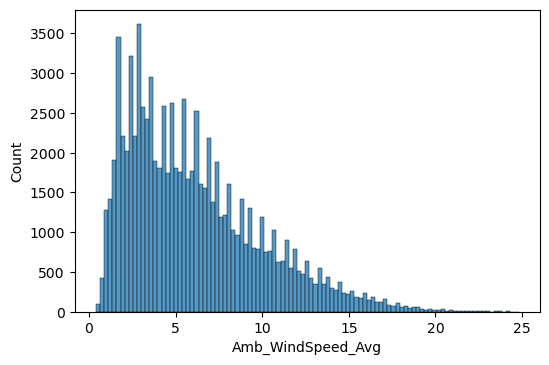

In [7]:
sns.histplot(signals_T01.Amb_WindSpeed_Avg)

In [8]:
wind_split = [3, 3.5, 4, 4.5, 5, 5.5, 6, 7, 9, 12]

<AxesSubplot:xlabel='Amb_Temp_Avg', ylabel='Count'>

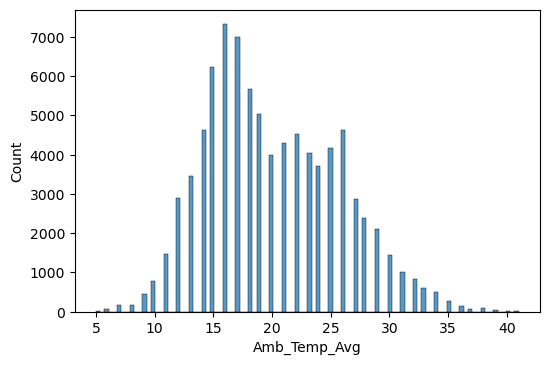

In [9]:
sns.histplot(signals_T01.Amb_Temp_Avg)

In [10]:
temp_split = [12, 15, 18, 20, 22, 25, 30, 35]

In [11]:
slices_T01 = slice_signals(signals_T01, Wind=wind_split, Temp=temp_split)

There were not enough observations (3) in (Interval(0.399, 3.0, closed='right'), Interval(12.0, 15.0, closed='right'))
There were not enough observations (2) in (Interval(0.399, 3.0, closed='right'), Interval(15.0, 18.0, closed='right'))
There were not enough observations (1) in (Interval(0.399, 3.0, closed='right'), Interval(18.0, 20.0, closed='right'))
There were not enough observations (2) in (Interval(0.399, 3.0, closed='right'), Interval(20.0, 22.0, closed='right'))
There were not enough observations (4) in (Interval(0.399, 3.0, closed='right'), Interval(22.0, 25.0, closed='right'))
There were not enough observations (8) in (Interval(0.399, 3.0, closed='right'), Interval(25.0, 30.0, closed='right'))
There were not enough observations (66) in (Interval(3.0, 3.5, closed='right'), Interval(4.999, 12.0, closed='right'))
There were not enough observations (84) in (Interval(3.0, 3.5, closed='right'), Interval(18.0, 20.0, closed='right'))
There were not enough observations (89) in (Inter

Podział został wyrównany. Nie staramy się wygładzić go jeszcze bardziej, gdyż zależy nam na pogrupowaniu obserwacji do podobnych warunków atmosferycznych, a drobniejszy podział mógłby zacierać różnice między grupami.

## Dopasowanie prostych do uśrednionych wartości mocy

Do każdej grupy dopasowujemy prostą w modelu regresji liniowej `Power_mean ~ Time`.

In [23]:
def make_regression(turbine_slices, visualize=False):
    results = {}
    cutting_variables = [c.replace("_cut", "") for c in turbine_slices[0][1].columns if "_cut" in c]
    for c in cutting_variables:
        results[c + "_lower"] = []
        results[c + "_upper"] = []
    results["Slope"] = []

    for group in turbine_slices:
        for i, cutter in enumerate(group[0]):
            results[cutting_variables[i] + "_lower"].append(cutter.left)
            results[cutting_variables[i] + "_upper"].append(cutter.right)
        time_group = group[1].groupby("Time_batch")
        group_centers = 0.5 * (time_group.first()["Time"] + time_group.last()["Time"])
        group_powers = time_group.first()["Power_mean"]
        model = _LinRegBasicModel(group_powers, group_centers)
        if visualize:
            sns.scatterplot(x=group[1].Time, y=group[1].Power)
            sns.scatterplot(x=group_centers, y=group_powers, marker="*", s=200)
            sns.lineplot(
                x=[group_centers[0], group_centers[len(group_centers) - 1]], 
                y=[group_centers[0] * model.beta[1] + model.beta[0],
                   group_centers[1] * model.beta[1] + model.beta[0]],
                color="red")
            plt.show()
        
        results["Slope"].append(model.beta[1])
                
    print(f"{sum(np.array(results['Slope']) < 0)} of {len(results['Slope'])} are less than zero.")
    return pd.DataFrame(results)

In [24]:
result_T01 = make_regression(slices_T01, visualize=False)

40 of 73 are less than zero.


In [25]:
def plot_results(result):
    sns.scatterplot(y=result.Slope, x = np.arange(0, result.shape[0]))
    sns.lineplot(y=[0, 0], x=[0, result.shape[0] - 1], color="red", dashes=[(2, 2)], style=True)
    sns.lineplot(y=[np.mean(result.Slope), np.mean(result.Slope)], x=[0, result.shape[0] - 1], color="red")
    plt.show()

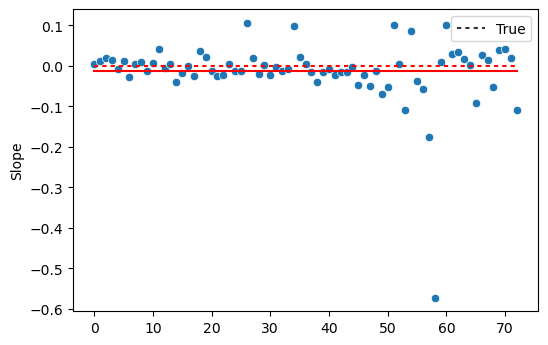

In [26]:
plot_results(result_T01)

## Analiza pozostałych turbin

There were not enough observations (22) in (Interval(0.399, 3.0, closed='right'), Interval(4.999, 12.0, closed='right'))
There were not enough observations (20) in (Interval(0.399, 3.0, closed='right'), Interval(12.0, 15.0, closed='right'))
There were not enough observations (10) in (Interval(0.399, 3.0, closed='right'), Interval(15.0, 18.0, closed='right'))
There were not enough observations (3) in (Interval(0.399, 3.0, closed='right'), Interval(18.0, 20.0, closed='right'))
There were not enough observations (2) in (Interval(0.399, 3.0, closed='right'), Interval(20.0, 22.0, closed='right'))
There were not enough observations (1) in (Interval(0.399, 3.0, closed='right'), Interval(22.0, 25.0, closed='right'))
There were not enough observations (1) in (Interval(0.399, 3.0, closed='right'), Interval(25.0, 30.0, closed='right'))
There were not enough observations (6) in (Interval(0.399, 3.0, closed='right'), Interval(30.0, 35.0, closed='right'))
There were not enough observations (139) in 

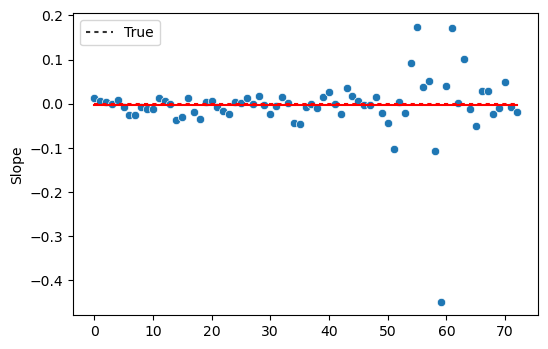

In [27]:
slices_T06 = slice_signals(signals_T06, Wind=wind_split, Temp=temp_split)
result_T06 = make_regression(slices_T06, visualize=False)
plot_results(result_T06)

There were not enough observations (1) in (Interval(0.499, 3.0, closed='right'), Interval(3.999, 12.0, closed='right'))
There were not enough observations (2) in (Interval(0.499, 3.0, closed='right'), Interval(15.0, 18.0, closed='right'))
There were not enough observations (4) in (Interval(0.499, 3.0, closed='right'), Interval(20.0, 22.0, closed='right'))
There were not enough observations (1) in (Interval(0.499, 3.0, closed='right'), Interval(25.0, 30.0, closed='right'))
There were not enough observations (1) in (Interval(0.499, 3.0, closed='right'), Interval(30.0, 35.0, closed='right'))
There were not enough observations (98) in (Interval(3.0, 3.5, closed='right'), Interval(3.999, 12.0, closed='right'))
There were not enough observations (72) in (Interval(3.0, 3.5, closed='right'), Interval(18.0, 20.0, closed='right'))
There were not enough observations (83) in (Interval(3.0, 3.5, closed='right'), Interval(20.0, 22.0, closed='right'))
There were not enough observations (69) in (Inter

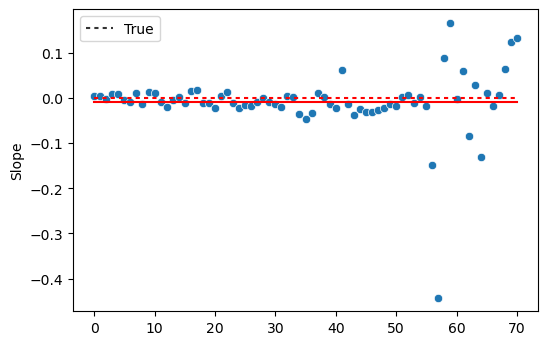

In [17]:
slices_T07 = slice_signals(signals_T07, Wind=wind_split, Temp=temp_split)
result_T07 = make_regression(slices_T07, visualize=False)
plot_results(result_T07)

There were not enough observations (2) in (Interval(0.399, 3.0, closed='right'), Interval(3.999, 12.0, closed='right'))
There were not enough observations (7) in (Interval(0.399, 3.0, closed='right'), Interval(12.0, 15.0, closed='right'))
There were not enough observations (1) in (Interval(0.399, 3.0, closed='right'), Interval(15.0, 18.0, closed='right'))
There were not enough observations (2) in (Interval(0.399, 3.0, closed='right'), Interval(18.0, 20.0, closed='right'))
There were not enough observations (1) in (Interval(0.399, 3.0, closed='right'), Interval(20.0, 22.0, closed='right'))
There were not enough observations (3) in (Interval(0.399, 3.0, closed='right'), Interval(22.0, 25.0, closed='right'))
There were not enough observations (7) in (Interval(0.399, 3.0, closed='right'), Interval(25.0, 30.0, closed='right'))
There were not enough observations (1) in (Interval(0.399, 3.0, closed='right'), Interval(30.0, 35.0, closed='right'))
There were not enough observations (107) in (In

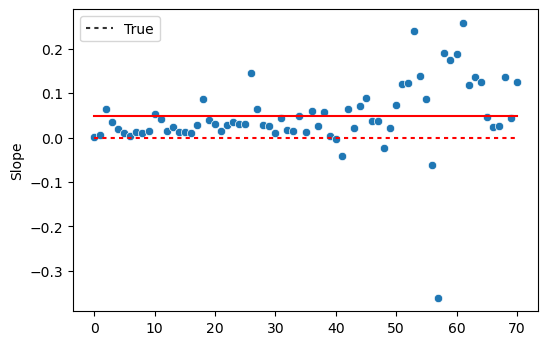

In [18]:
slices_T09 = slice_signals(signals_T09, Wind=wind_split, Temp=temp_split)
result_T09 = make_regression(slices_T09, visualize=False)
plot_results(result_T09)

There were not enough observations (2) in (Interval(0.399, 3.0, closed='right'), Interval(4.999, 12.0, closed='right'))
There were not enough observations (10) in (Interval(0.399, 3.0, closed='right'), Interval(12.0, 15.0, closed='right'))
There were not enough observations (1) in (Interval(0.399, 3.0, closed='right'), Interval(15.0, 18.0, closed='right'))
There were not enough observations (3) in (Interval(0.399, 3.0, closed='right'), Interval(18.0, 20.0, closed='right'))
There were not enough observations (6) in (Interval(0.399, 3.0, closed='right'), Interval(20.0, 22.0, closed='right'))
There were not enough observations (5) in (Interval(0.399, 3.0, closed='right'), Interval(22.0, 25.0, closed='right'))
There were not enough observations (6) in (Interval(0.399, 3.0, closed='right'), Interval(25.0, 30.0, closed='right'))
There were not enough observations (1) in (Interval(0.399, 3.0, closed='right'), Interval(30.0, 35.0, closed='right'))
There were not enough observations (113) in (I

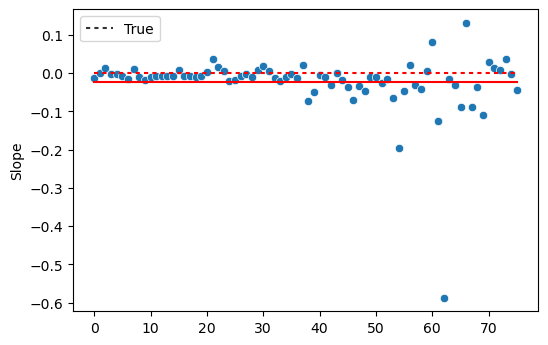

In [19]:
slices_T11 = slice_signals(signals_T11, Wind=wind_split, Temp=temp_split)
result_T11 = make_regression(slices_T11, visualize=False)
plot_results(result_T11)

## Wnioski

Na powyższych wykresach przerywaną linią zaznaczono prostą $y=0$, a ciągłą średni współczynnik kierunkowy otrzymany z modeli regresji.

Turbina 9 działa w pełni sprawnie i nie starzeje się w czasie.

Na wykresach widać również, że im większe wartości wiatru (dalej w prawo), tym wyniki są bardziej chaotyczne i przypadkowe. Analizę powtórzymy zatem z wycięciem obserwacji, które nie dają się prognozować.

Widać także cykliczność w początkowych kilkunastu punktach, gdzie co piąta obserwacja wybija się w górę. Odpowiada ona najniższej możliwej grupie temperaturowej, gdzie sprawność nie jest pogarszana z czasem.